# Accuracy Assessment of dNBR Classification <img align="right" src="../DEA reference notebooks/Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI VDI` or a `Local` environment only.
* **Products derived from previously processed data:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[planet_dove](https://planet.com)

## Background
During the 2020 Black Summer Bushfires, the town of Tumbarumba, NSW was impacted by a fire event that occured on the 05 Jan 2020. This notebook is a supporting notebook to the `differenced normalised burn ratio` notebook. Having already produced the output dNBR GeoTIFF product, Planet Data (sourced under a Planet education and research license) was used to extract and classify points in accordance with the fire severity classes (unburt, low, moderate, high extreme). Producing accuracy assessments is critical to validating the results produced.

## Description
This notebook is used to generate accuracy results for fire severity and fire extent. No connection is required to the NCI, as no connection to the datacube is required. Accuracy data (derived from Planet Dove imagery) has been provided as a shapefile and includes the dNBR value, the actual severity that was visually interpretted and the geometry. This notebook is split into the following sections:

1. Import required modules
2. Read in accuracy data
3. Calculate fire severity and fire extent accuracy results (users, producers and overall).

***

## Getting started

### Load packages

In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

### Read in Data

In [2]:
gdf = gpd.read_file("./training_accuracy_data.shp")
gdf = gdf.rename(columns={"Tumbarumba": "dNBR", "SEVERITY": "actual_severity"})
gdf.head()

,dNBR,actual_severity,geometry
0,-0.04120,Unburnt,POINT (620890.643 5981712.721)
1,0.58526,Moderate,POINT (584229.417 5980124.584)
2,0.20552,Low,POINT (585809.421 5980766.175)
3,0.31326,Moderate,POINT (623375.568 6070297.326)
4,0.00954,Unburnt,POINT (619427.841 6050698.299)


__From dNBR raster histogram:__<br>
mix value = -0.78936<br>
max value = 1.2721

Separate each class into separate geodataframes based on the actual (measured) classes:

In [3]:
actual_unburnt = gdf.loc[(gdf["actual_severity"] == "Unburnt")]
actual_low = gdf.loc[(gdf["actual_severity"] == "Low")]
actual_moderate = gdf.loc[(gdf["actual_severity"] == "Moderate")]
actual_high = gdf.loc[(gdf["actual_severity"] == "High")]
actual_extreme = gdf.loc[(gdf["actual_severity"] == "Extreme")]

Plot the classes (less unburnt) on a histogram to find threshold values for separation:

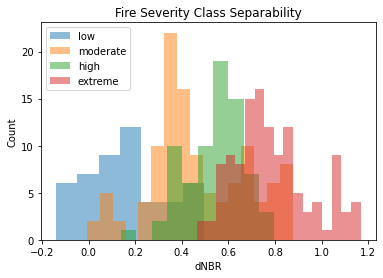

In [4]:
# plt.hist(actual_unburnt['dNBR'], bins=30, alpha = 0.5, label='unburnt')
plt.hist(actual_low["dNBR"], bins=7, alpha=0.5, label="low")
plt.hist(actual_moderate["dNBR"], bins=16, alpha=0.5, label="moderate")
plt.hist(actual_high["dNBR"], bins=10, alpha=0.5, label="high")
plt.hist(actual_extreme["dNBR"], bins=17, alpha=0.5, label="extreme")

plt.legend(loc="upper left")

plt.xlabel("dNBR")
plt.ylabel("Count")
plt.title("Fire Severity Class Separability")

plt.savefig("class_separability_severity.png")
plt.show()

Extremely poor separability between classes. This could be due to the accuracy data that was sourced by visually intepreting 3m resolution Planet Dove data using false colour cues. It was easy to identify 'extreme' classes that were completed charred and also unburnt healthy areas but distinguishing between low, moderate and high was very difficult.

Apply threshold values and map the categorical matches to the original geodataframe:

In [5]:
classified_unburnt = gdf.loc[(gdf["dNBR"] < 0.10)]
classified_low = gdf.loc[(gdf["dNBR"] >= 0.10) & (gdf["dNBR"] < 0.30)]
classified_moderate = gdf.loc[(gdf["dNBR"] >= 0.30) & (gdf["dNBR"] < 0.50)]
classified_high = gdf.loc[(gdf["dNBR"] >= 0.50) & (gdf["dNBR"] < 0.65)]
classified_extreme = gdf.loc[(gdf["dNBR"] >= 0.65)]

In [6]:
classified_unburnt = classified_unburnt.assign(classified_severity="Unburnt")
classified_low = classified_low.assign(classified_severity="Low")
classified_moderate = classified_moderate.assign(classified_severity="Moderate")
classified_high = classified_high.assign(classified_severity="High")
classified_extreme = classified_extreme.assign(classified_severity="Extreme")

Combined the results into a new geodataframe and produce a crosstab (accuracy matrix):

In [7]:
frames = [
    classified_unburnt,
    classified_low,
    classified_moderate,
    classified_high,
    classified_extreme,
]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results_duplicate = results  # used later on
results.head()

,dNBR,actual_severity,classified_severity,geometry
0,-0.04120,Unburnt,Unburnt,POINT (620890.643 5981712.721)
4,0.00954,Unburnt,Unburnt,POINT (619427.841 6050698.299)
6,-0.05770,Unburnt,Unburnt,POINT (618872.144 5981099.339)
7,-0.14799,Unburnt,Unburnt,POINT (614146.389 6011331.299)
10,-0.07889,Unburnt,Unburnt,POINT (613935.682 6011263.956)


In [8]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Low", "Moderate", "High", "Extreme"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab.to_csv("./dNBR_accuracy_severity_skewed.csv")
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,674,45,25,4,0
Low,16,20,12,0,0
Moderate,7,11,54,12,29
High,0,2,22,35,14
Extreme,0,0,2,21,99


In [9]:
overall_accuracy = (
    (
        xtab["Unburnt"]["Unburnt"]
        + xtab["Low"]["Low"]
        + xtab["Moderate"]["Moderate"]
        + xtab["High"]["High"]
        + xtab["Extreme"]["Extreme"]
    )
    / len(gdf)
    * 100
)

overall_accuracy

79.8913043478261

In [10]:
gdf.groupby("actual_severity").count()

,dNBR,geometry
actual_severity,,
Extreme,122,122
High,73,73
Low,48,48
Moderate,113,113
Unburnt,748,748


### Discussion
There is a disproportionally high number of unburnt sample points which have likely skewed the results to be very high. We only need to look at the count to see that unburnt samples make up a majority of the points. Let's see what happens if only 40 points from each class are randomly sampled.

In [11]:
unburnt = results.loc[(gdf["actual_severity"] == "Unburnt")]
unburnt = unburnt.sample(n=40)

low = results.loc[(gdf["actual_severity"] == "Low")]
low = low.sample(n=40)

moderate = results.loc[(gdf["actual_severity"] == "Moderate")]
moderate = moderate.sample(n=40)

high = results.loc[(gdf["actual_severity"] == "High")]
high = high.sample(n=40)

extreme = results.loc[(gdf["actual_severity"] == "Extreme")]
extreme = extreme.sample(n=40)

In [12]:
frames = [unburnt, low, moderate, high, extreme]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results.head()

,dNBR,actual_severity,classified_severity,geometry
314,0.02703,Unburnt,Unburnt,POINT (619965.629 6050805.523)
671,-0.09013,Unburnt,Unburnt,POINT (622594.954 6080638.351)
418,0.01035,Unburnt,Unburnt,POINT (544694.871 5984661.600)
294,0.00020,Unburnt,Unburnt,POINT (608819.625 6053457.184)
482,-0.05578,Unburnt,Unburnt,POINT (621432.005 6079753.704)


In [13]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Low", "Moderate", "High", "Extreme"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab.to_csv("./dNBR_accuracy_severity_random.csv")
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,37,0,3,0,0
Low,15,16,9,0,0
Moderate,2,2,21,4,11
High,0,1,12,18,9
Extreme,0,0,0,5,35


In [14]:
overall_accuracy = (
    (
        xtab["Unburnt"]["Unburnt"]
        + xtab["Low"]["Low"]
        + xtab["Moderate"]["Moderate"]
        + xtab["High"]["High"]
        + xtab["Extreme"]["Extreme"]
    )
    / len(results)
    * 100
)

overall_accuracy

63.5

This is likely a far more accurate representation of the overall accuracy of this classification. This is still not based considering the very minimal processing overhead for a dNBR compared to a multi-band fully connected neural network approach. Unfortunately, with each different location, scene, weather conditions (pre/post), vegetation ecosystems etc; there is significant variability that the chose threshold values would need to be tweaked to suit each scene. This is where a majority of the time would be spent, and normalising severity from one scene to another become very difficult as moderate in one may not neccessarily map well to moderate in another location with a completely different ecosystem of flora.

Lets look at the accuracy if the only two endmembers were 'Unburnt' or 'Burnt' areas. In order to do this, we re-map low, moderate, high and extreme categorisations in the actual and classified severity columns to 'burnt' and reproduce the crosstab.

In [15]:
results_duplicate.loc[
    results_duplicate.actual_severity == "Low", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "Moderate", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "High", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "Extreme", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Low", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Moderate", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "High", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Extreme", "classified_severity"
] = "Burnt"

In [16]:
results_duplicate.head()

,dNBR,actual_severity,classified_severity,geometry
0,-0.04120,Unburnt,Unburnt,POINT (620890.643 5981712.721)
4,0.00954,Unburnt,Unburnt,POINT (619427.841 6050698.299)
6,-0.05770,Unburnt,Unburnt,POINT (618872.144 5981099.339)
7,-0.14799,Unburnt,Unburnt,POINT (614146.389 6011331.299)
10,-0.07889,Unburnt,Unburnt,POINT (613935.682 6011263.956)


In [17]:
unburnt = results_duplicate.loc[(results_duplicate["actual_severity"] == "Unburnt")]
unburnt = unburnt.sample(n=160)

burnt = results_duplicate.loc[(results_duplicate["actual_severity"] == "Burnt")]
burnt = burnt.sample(n=160)

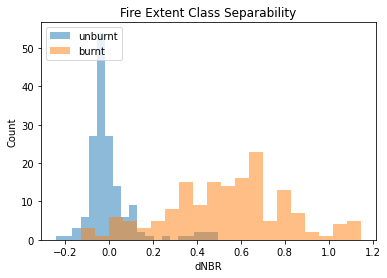

In [18]:
plt.hist(unburnt["dNBR"], bins=20, alpha=0.5, label="unburnt")
plt.hist(burnt["dNBR"], bins=20, alpha=0.5, label="burnt")

plt.legend(loc="upper left")

plt.xlabel("dNBR")
plt.ylabel("Count")
plt.title("Fire Extent Class Separability")

plt.savefig("class_separability_extent.png")
plt.show()

In [19]:
frames = [unburnt, burnt]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results.head()

,dNBR,actual_severity,classified_severity,geometry
232,-0.08403,Unburnt,Unburnt,POINT (621556.897 6079711.928)
1050,-0.00610,Unburnt,Unburnt,POINT (606999.560 6022200.241)
650,0.11247,Unburnt,Burnt,POINT (619252.590 6052092.973)
922,-0.05074,Unburnt,Unburnt,POINT (625547.449 5984952.798)
916,0.09580,Unburnt,Unburnt,POINT (619722.073 6050258.325)


In [20]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Burnt"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab.to_csv("./dNBR_accuracy_extent_random.csv")
xtab

classified_severity,Unburnt,Burnt
actual_severity,,
Unburnt,144,16
Burnt,13,147


In [21]:
overall_accuracy = (
    (xtab["Unburnt"]["Unburnt"] + xtab["Burnt"]["Burnt"]) / len(results) * 100
)

overall_accuracy

90.9375

Overall, the accuracy of the dNBR in identifying between unburnt and burnt areas is approximately 90%. This is very high and a decent result for the identification of burn area extent or boundaries. A good way to really test this however would be to sample many points across known boundary areas in order to determine if the same accuracy still holds.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Last modified:** 03 Nov 2020.

## Tags